In [ ]:
from datasets import load_from_disk

SEED = 123
FOLDER = "../data/processed/legal-qa-v1"

In [ ]:
dataset = load_from_disk(FOLDER)

In [ ]:
#check the dataset
print(dataset)
print(dataset['train'][0])
print(dataset['validation'][0])
print(dataset['test'][0])

In [ ]:
dataset["answer"]

In [ ]:
def transform(example):
    # ejemplo: poner preguntas en mayúsculas y respuestas en minúsculas
    new_question = example["question"].replace("Q:", "").strip()
    new_answer = example["answer"].replace("A:", "").strip()

    return {
        "question": new_question,
        "answer": new_answer
    }

In [ ]:
transformed_dataset = dataset.map(transform)

In [ ]:
print(transformed_dataset["question"][0])
print(transformed_dataset["answer"][0])

In [ ]:
# split the dataset into train and validation
train_test = transformed_dataset.train_test_split(test_size=0.2, seed=SEED)
print(train_test)
train_val = train_test["test"].train_test_split(test_size=0.5, seed=SEED)
transformed_dataset = {
    "train": train_test["train"],
    "val": train_val["test"],
    "test": train_val["train"]
}

In [ ]:
transformed_dataset

## Embeddings

In [1]:
from typing import List
from langchain_core.embeddings import Embeddings
from sentence_transformers import SentenceTransformer


class SentenceTransformerEmbeddings(Embeddings):

    def __init__(self, model: str, device: str = 'cuda'):
        self.model = SentenceTransformer(model, device=device)

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed search docs."""
        return self.model.encode(texts).tolist()

    def embed_query(self, text: str) -> List[float]:
        """Embed query text."""
        return self.model.encode_query(text).tolist()

/home/miguel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_community.vectorstores import FAISS

model = SentenceTransformerEmbeddings(model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

loaded_vectorstore=FAISS.load_local(
    "../data/db/parliament_db/parliament_all_docs_embeddings_sentence-transformers_paraphrase-multilingual-mpnet-base-v2",
    model,
    allow_dangerous_deserialization=True
)

print(f"Loaded vector store contains {loaded_vectorstore.index.ntotal} vectors")

Loaded vector store contains 11162 vectors


In [3]:
# get all embeddings in numpy array
import numpy as np
all_embeddings = np.array([emb for emb in loaded_vectorstore.index.reconstruct_n(0, loaded_vectorstore.index.ntotal)])
print(f"All embeddings shape: {all_embeddings.shape}")

All embeddings shape: (11162, 768)


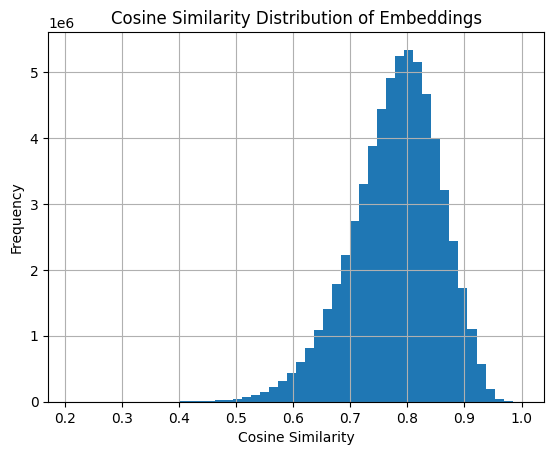

In [5]:
# plot histogram of the embeddings cosine similarity distribution

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(all_embeddings)
# get the upper triangle of the cosine similarities matrix, without the diagonal
upper_triangle_indices = np.triu_indices_from(cosine_similarities, k=1)
upper_triangle_values = cosine_similarities[upper_triangle_indices]

plt.hist(upper_triangle_values, bins=50)
plt.grid()
plt.title("Cosine Similarity Distribution of Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [6]:
# print the mean and standard deviation of the cosine similarities
mean_cosine_similarity = np.mean(upper_triangle_values)
std_cosine_similarity = np.std(upper_triangle_values)
# print the results rounded to 4 decimal places
print(f"Mean Cosine Similarity: {mean_cosine_similarity:.4f}")
print(f"Standard Deviation of Cosine Similarity: {std_cosine_similarity:.4f}")

Mean Cosine Similarity: 0.7794
Standard Deviation of Cosine Similarity: 0.0769


In [ ]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench_hotpotqa = load_dataset("rungalileo/ragbench", "hotpotqa")
print(ragbench_hotpotqa)

In [ ]:
ragbench = {}
for dataset in ['covidqa', 'cuad', 'delucionqa', 'emanual', 'expertqa', 'finqa', 'hagrid', 'hotpotqa', 'msmarco', 'pubmedqa', 'tatqa', 'techqa']:
  ragbench[dataset] = load_dataset("rungalileo/ragbench", dataset)

In [ ]:
ragbench

In [ ]:
ragbench["covidqa"]["train"][0]

In [ ]:
## quiero solo estas columnas
columns_to_keep = ["id", "question", "documents", "response"]
for subset in ragbench:
    ragbench[subset] = ragbench[subset].remove_columns([col for col in ragbench[subset]['train'].column_names if col not in columns_to_keep])

In [ ]:
document = []
for split in ragbench["covidqa"]:
    for docs in ragbench["covidqa"][split]["documents"]:
        for doc in docs:
            document.append(doc)

In [ ]:
len(document)

In [ ]:
# check unique documents in alphabetical order
len(set(document))
unique_documents = list(set(document))
unique_documents.sort()

In [ ]:
# create new column with the idx of the document in the list of unique documents, the idx should be a list of integers and the name of the column should be "document_ids"
unique_documents = list(set(document))
unique_documents.sort()
document_idx_map = {doc: idx for idx, doc in enumerate(unique_documents)}
for split in ragbench["covidqa"]:
    ragbench["covidqa"][split] = ragbench["covidqa"][split].add_column(
        "document_ids",
        [[document_idx_map[doc] for doc in docs] for docs in ragbench["covidqa"][split]["documents"]]
    )
ragbench["covidqa"]["train"][0]

In [ ]:
# save to disk the list of unique documents in jsonl format
import os
import json

with open("../data/processed/ragbench/covidqa_unique_documents.jsonl", "w") as f:
    for doc in unique_documents:
        f.write(json.dumps({"document": doc}) + "\n")

# Parliamentary data

In [ ]:
from datasets import load_from_disk
FOLDER_AUTORE = "../data/raw/ORDERS_PARLIAMENT" # Entrenamiento autoregresivo

In [ ]:
dataset_aut = load_from_disk(FOLDER_AUTORE) 

In [ ]:
dataset_aut["train"][0]

In [ ]:
print(dataset_aut['train'][0])

In [ ]:
import json
FOLDER_QA = "../data/raw/QA_PARLIAMENT_TRAIN"

dataset_qa = load_from_disk(FOLDER_QA)
print(dataset_qa)
print(dataset_qa["train"])
print(json.dumps(dataset_qa['train'][3], indent=2))

In [ ]:
doc = dataset_qa["train"][10]["context"]
print(doc)

In [ ]:
doc.replace("[Documento]:", "").strip()

In [ ]:
import json
FOLDER_QA = "../data/raw/QA_PARLIAMENT_TEST"

dataset_qa = load_from_disk(FOLDER_QA)
print(dataset_qa["test"])
print(json.dumps(dataset_qa['test'][3], indent=2))

In [ ]:
doc = dataset_qa["test"][3]["formatted_context"]
print(doc)

In [ ]:
pks = dataset_qa["test"][:]['PK']
print(pks)
# hay algunos pk vacíos?
pks.count("")

pk_1 = pks[1]

# buscar en dataset_aut 



In [ ]:
dataset = load_from_disk("../data/processed/parliament_all_docs")
print(dataset)

In [ ]:
for i in dataset:
    print(i)